[LOAD] IRON_I
[LOAD] IRON_II
[LOAD] IRON_III
[LOAD] IRON_IV
[LOAD] BRONZE_I
[LOAD] BRONZE_II
[LOAD] BRONZE_III
[LOAD] BRONZE_IV
[LOAD] SILVER_I
[LOAD] SILVER_II
[LOAD] SILVER_III
[LOAD] SILVER_IV
[LOAD] GOLD_I
[LOAD] GOLD_II
[LOAD] GOLD_III
[LOAD] GOLD_IV
[LOAD] PLATINUM_I
[LOAD] PLATINUM_II
[LOAD] PLATINUM_III
[LOAD] PLATINUM_IV
[LOAD] EMERALD_I
[LOAD] EMERALD_II
[LOAD] EMERALD_III
[LOAD] EMERALD_IV
[LOAD] DIAMOND_I
[LOAD] DIAMOND_II
[LOAD] DIAMOND_III
[LOAD] DIAMOND_IV
[LOAD] MASTER
[LOAD] GRANDMASTER
[LOAD] CHALLENGER

[PLOT] IRON


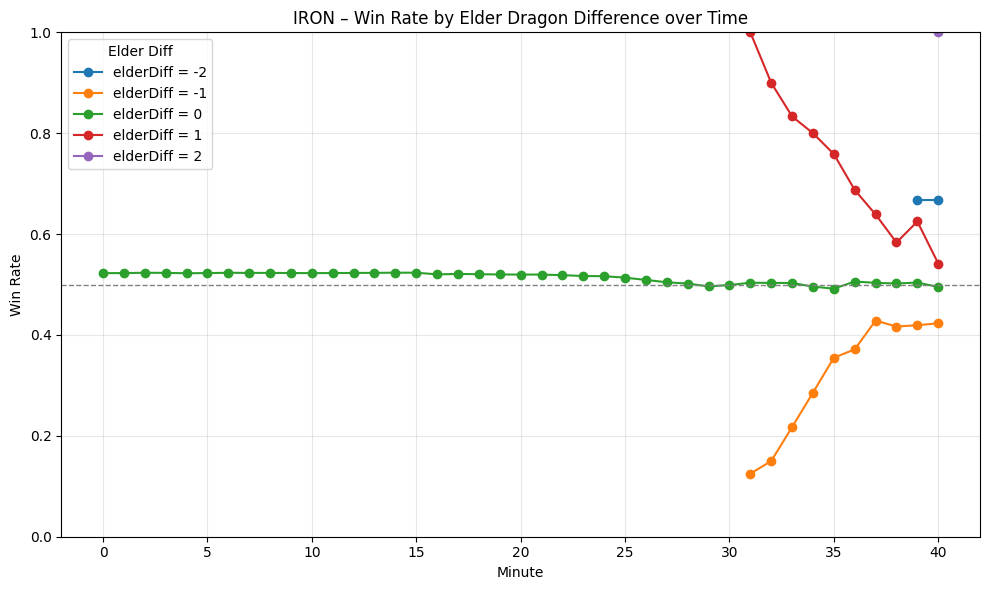


[PLOT] BRONZE


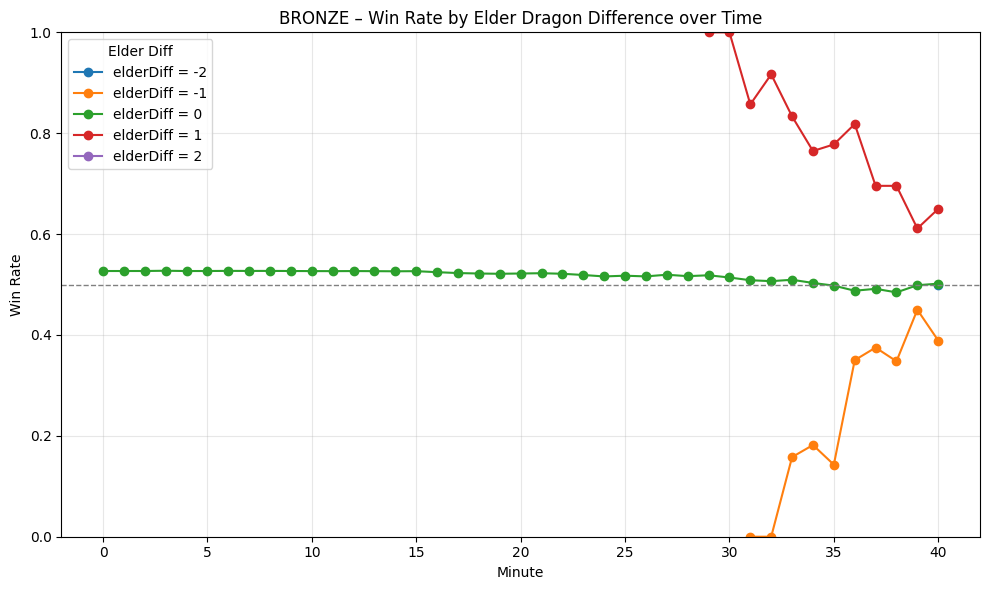


[PLOT] SILVER


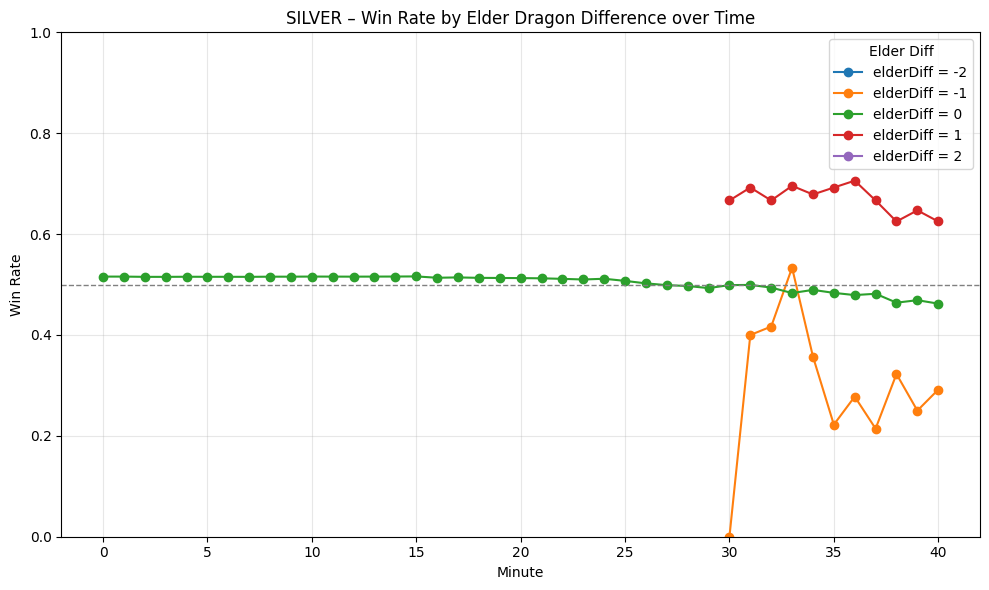


[PLOT] GOLD


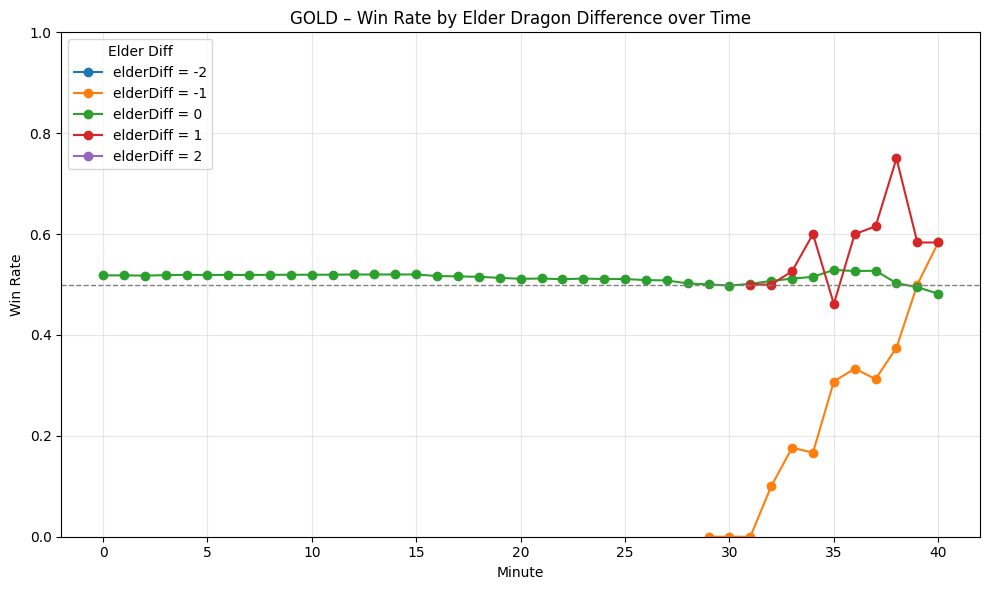


[PLOT] PLATINUM


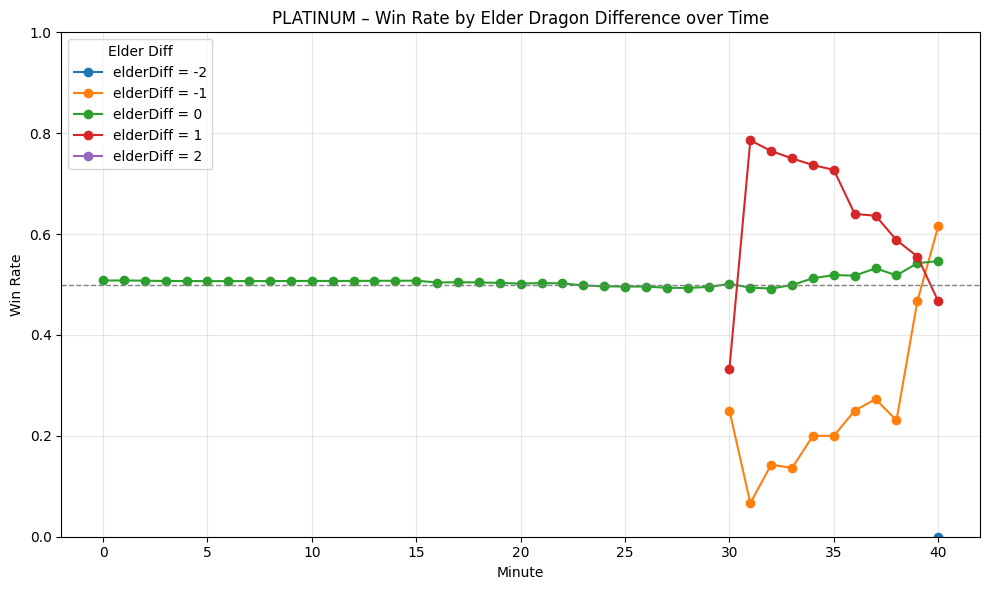


[PLOT] EMERALD


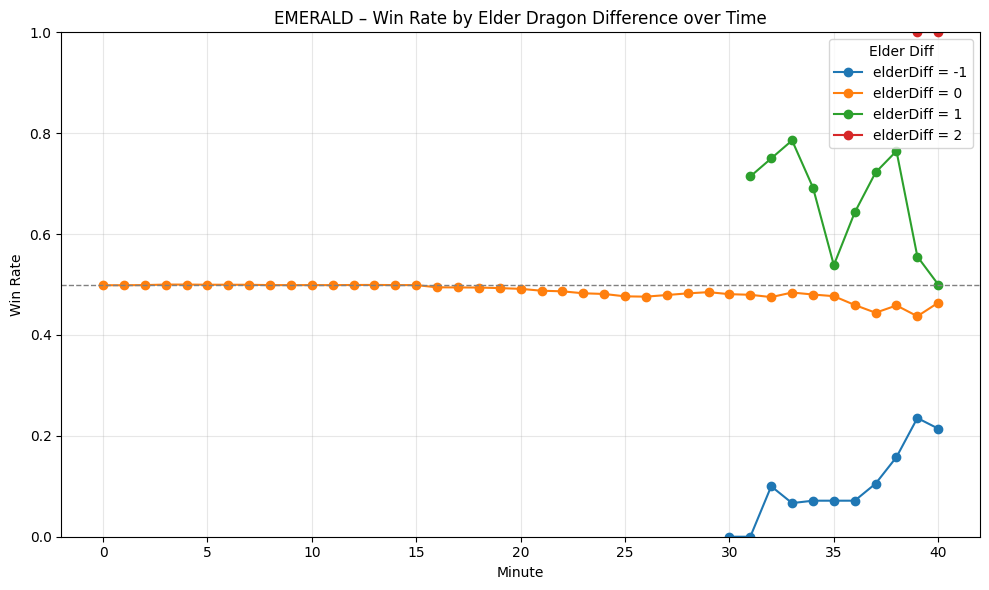


[PLOT] DIAMOND


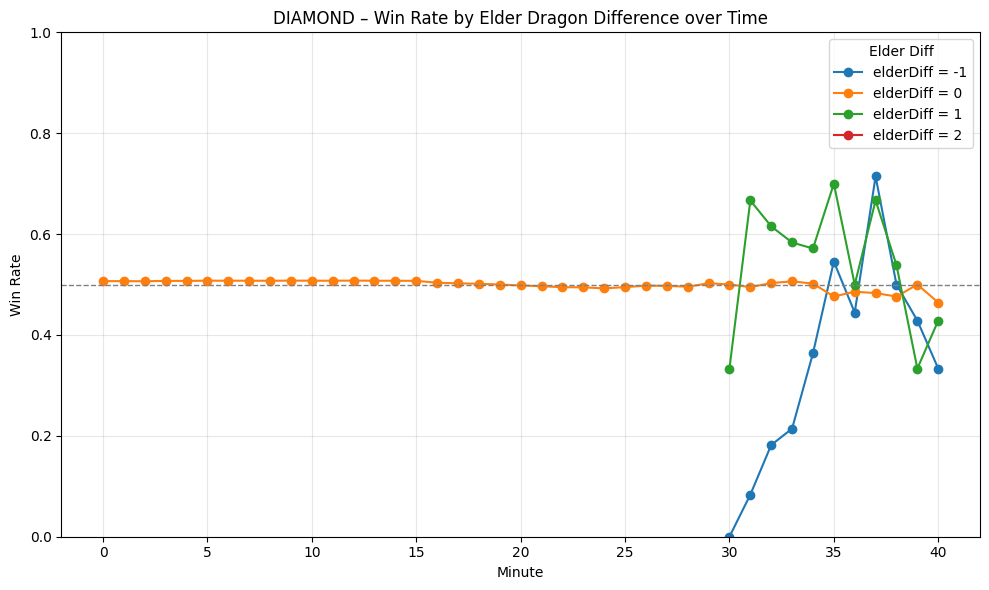


[PLOT] MASTER


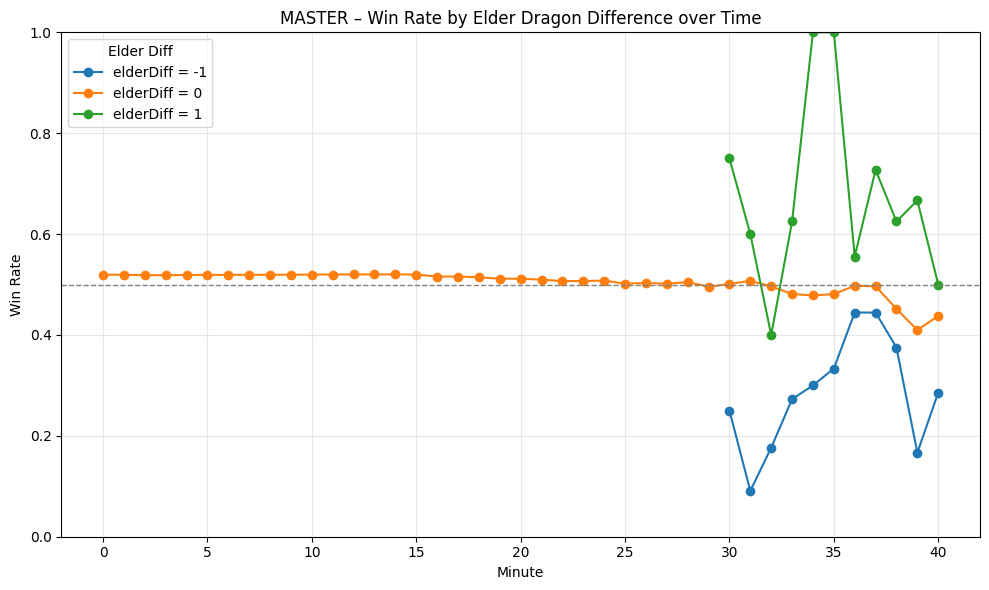


[PLOT] GRANDMASTER


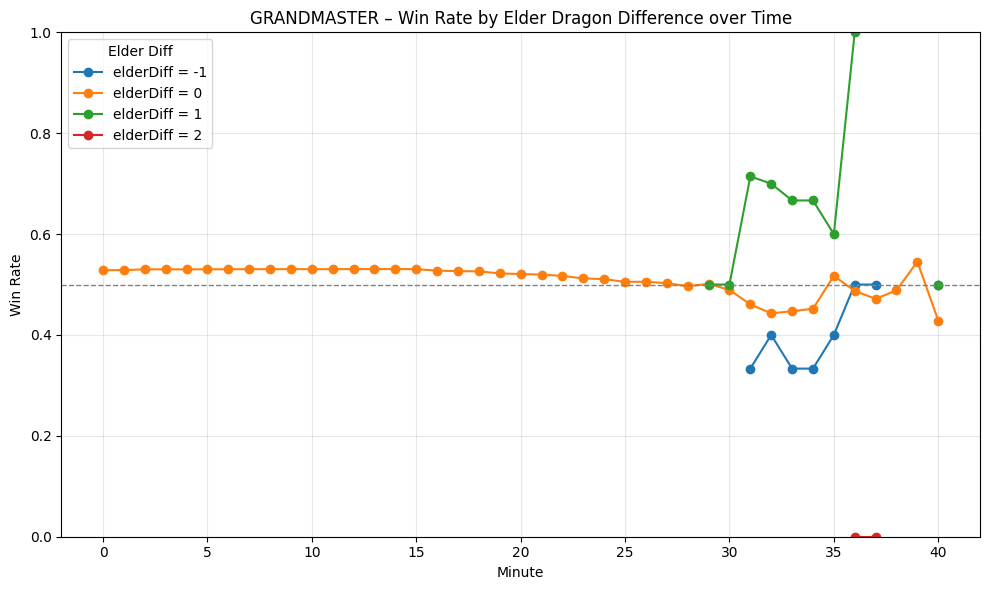


[PLOT] CHALLENGER


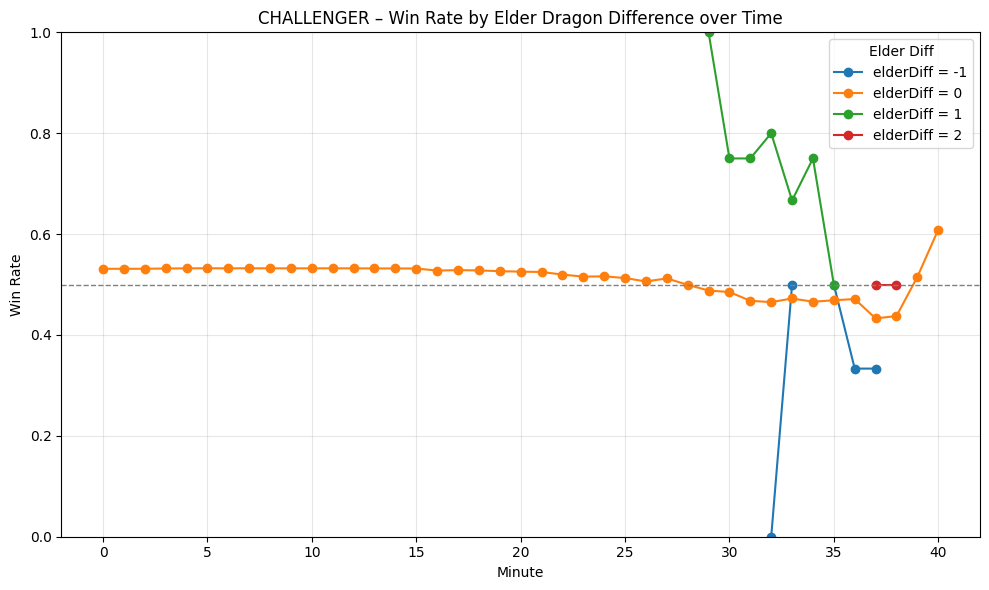

In [2]:
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt

# ===============================
# 0. 설정
# ===============================
BASE_PATH = "../../../data/processed"

TIERS = [
    "IRON_I", "IRON_II", "IRON_III", "IRON_IV",
    "BRONZE_I", "BRONZE_II", "BRONZE_III", "BRONZE_IV",
    "SILVER_I", "SILVER_II", "SILVER_III", "SILVER_IV",
    "GOLD_I", "GOLD_II", "GOLD_III", "GOLD_IV",
    "PLATINUM_I", "PLATINUM_II", "PLATINUM_III", "PLATINUM_IV",
    "EMERALD_I", "EMERALD_II", "EMERALD_III", "EMERALD_IV",
    "DIAMOND_I", "DIAMOND_II", "DIAMOND_III", "DIAMOND_IV",
    "MASTER", "GRANDMASTER", "CHALLENGER"
]

TIER_ORDER = [
    "IRON", "BRONZE", "SILVER", "GOLD",
    "PLATINUM", "EMERALD", "DIAMOND",
    "MASTER", "GRANDMASTER", "CHALLENGER"
]

TARGET_METRIC = "elderDiff"
MAX_MINUTE = 40
MIN_SAMPLE = 10

# ===============================
# 1. 보조 함수
# ===============================
def get_major_tier(tier_name: str) -> str:
    return tier_name.split("_")[0] if "_" in tier_name else tier_name


# ===============================
# 2. timeline → long_df
# ===============================
rows = []
diff_pattern = re.compile(r"(.*Diff)_(\d+)$")

for tier in TIERS:
    timeline_path = f"{BASE_PATH}/{tier}_timeline.csv"
    matches_path  = f"{BASE_PATH}/{tier}_matches.csv"

    if not os.path.exists(timeline_path):
        continue

    print(f"[LOAD] {tier}")

    timeline = pd.read_csv(timeline_path)
    matches  = pd.read_csv(matches_path)

    winner_team = (
        matches[matches["win"] == 1]
        .rename(columns={"teamId": "winnerTeamId"})[["matchId", "winnerTeamId"]]
    )

    df = timeline.merge(winner_team, on="matchId", how="left")
    df["win"] = (df["winnerTeamId"] == 100).astype(int)

    major_tier = get_major_tier(tier)

    elder_cols = {}
    for col in df.columns:
        m = diff_pattern.match(col)
        if m:
            metric, minute = m.group(1), int(m.group(2))
            if metric == TARGET_METRIC and minute <= MAX_MINUTE:
                elder_cols[minute] = col

    for _, row in df.iterrows():
        for minute, col in elder_cols.items():
            rows.append({
                "tier": major_tier,
                "minute": minute,
                "elderDiff": row[col],
                "win": row["win"]
            })

long_df = pd.DataFrame(rows)

# ===============================
# 3. 티어별 선그래프
# ===============================
for tier_name in TIER_ORDER:
    print(f"\n[PLOT] {tier_name}")

    tier_df = long_df[long_df["tier"] == tier_name]

    grouped = (
        tier_df
        .groupby(["elderDiff", "minute"])
        .agg(
            win_rate=("win", "mean"),
            samples=("win", "count")
        )
        .reset_index()
    )

    grouped.loc[grouped["samples"] < MIN_SAMPLE, "win_rate"] = np.nan

    plt.figure(figsize=(10, 6))

    for diff in sorted(grouped["elderDiff"].dropna().unique()):
        sub = grouped[grouped["elderDiff"] == diff]
        plt.plot(
            sub["minute"],
            sub["win_rate"],
            marker="o",
            label=f"elderDiff = {int(diff)}"
        )

    plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)

    plt.title(f"{tier_name} – Win Rate by Elder Dragon Difference over Time")
    plt.xlabel("Minute")
    plt.ylabel("Win Rate")
    plt.ylim(0, 1)
    plt.legend(title="Elder Diff")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


In [3]:
# ===============================
# 7. 이미지 파일로 저장 (Elder Dragon → Line Plot)
# ===============================
SAVE_DIR = "../../../data/analysis/graph/elder"
os.makedirs(SAVE_DIR, exist_ok=True)

for tier_name in sorted(long_df["tier"].unique()):
    print(f"[SAVE] {tier_name}")

    grouped = (
        long_df[long_df["tier"] == tier_name]
        .groupby(["elderDiff", "minute"])
        .agg(
            win_rate=("win", "mean"),
            samples=("win", "count")
        )
        .reset_index()
    )

    # 샘플 수 부족 제거
    grouped.loc[grouped["samples"] < MIN_SAMPLE, "win_rate"] = np.nan

    plt.figure(figsize=(10, 6))

    for diff in sorted(grouped["elderDiff"].dropna().unique()):
        sub = grouped[grouped["elderDiff"] == diff]

        plt.plot(
            sub["minute"],
            sub["win_rate"],
            marker="o",
            label=f"elderDiff = {int(diff)}"
        )

    plt.axhline(0.5, color="gray", linestyle="--", linewidth=1)

    plt.title(f"{tier_name} – Win Rate by Elder Dragon Difference over Time")
    plt.xlabel("Minute")
    plt.ylabel("Win Rate")
    plt.ylim(0, 1)
    plt.legend(title="Elder Diff")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    save_path = os.path.join(
        SAVE_DIR,
        f"{tier_name}_elder_winrate_line.png"
    )

    plt.savefig(save_path, dpi=300)
    plt.close()

    print(f"[SAVED] {save_path}")


[SAVE] BRONZE
[SAVED] ../../../data/analysis/graph/elder\BRONZE_elder_winrate_line.png
[SAVE] CHALLENGER
[SAVED] ../../../data/analysis/graph/elder\CHALLENGER_elder_winrate_line.png
[SAVE] DIAMOND
[SAVED] ../../../data/analysis/graph/elder\DIAMOND_elder_winrate_line.png
[SAVE] EMERALD
[SAVED] ../../../data/analysis/graph/elder\EMERALD_elder_winrate_line.png
[SAVE] GOLD
[SAVED] ../../../data/analysis/graph/elder\GOLD_elder_winrate_line.png
[SAVE] GRANDMASTER
[SAVED] ../../../data/analysis/graph/elder\GRANDMASTER_elder_winrate_line.png
[SAVE] IRON
[SAVED] ../../../data/analysis/graph/elder\IRON_elder_winrate_line.png
[SAVE] MASTER
[SAVED] ../../../data/analysis/graph/elder\MASTER_elder_winrate_line.png
[SAVE] PLATINUM
[SAVED] ../../../data/analysis/graph/elder\PLATINUM_elder_winrate_line.png
[SAVE] SILVER
[SAVED] ../../../data/analysis/graph/elder\SILVER_elder_winrate_line.png
